# Ultilities

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import tqdm

def plot_distribution(array: np.ndarray, plot_name, unit_name, min, max) -> None:
    """
    Plots the distribution of a NumPy array using a histogram.

    Args:
        array (np.ndarray): Input array for which the distribution will be visualized.
    """
    # Plot the histogram
    if min is None:
        min = np.min(array)
    if max is None:
        max = np.max(array)
    array = array[(array >= min) & (array <= max)]
    plt.hist(array, color='lightgreen', ec='black', bins=1000)
    plt.xlabel(unit_name)
    plt.ylabel('Frequency')
    plt.title(plot_name)
    plt.show()

def relabel_data_based_on_threshold(smallest_threshold, input_df: pl.DataFrame, label_dict: dict):
    power_np = input_df.select("P").to_numpy()
    _max = power_np.max()
    _min = power_np.min()
    
    # Create a numpy array with dtype 'object' to hold string values
    label_np = np.zeros(len(power_np), dtype=object)
    no_device_idx = (power_np < smallest_threshold).reshape(len(power_np),)
    unlabeled_idx = (power_np >= smallest_threshold).reshape(len(power_np),)
    label_np[no_device_idx] = "no_device"
    label_np[unlabeled_idx] = "unlabeled"
    for key in label_dict.keys():
        min_threshold = label_dict[key][0] if label_dict[key][0] is not None else _min
        max_threshold = label_dict[key][1] if label_dict[key][1] is not None else _max
        relabeled_idx = np.array((power_np >= min_threshold) & (power_np <= max_threshold)).reshape(len(power_np),)
        label_np[relabeled_idx] = key
    input_df = input_df.with_columns(pl.Series(name="state_label", values=label_np))
    return input_df

def plot_data(input_df, which_plot: dict):
    plt.figure(figsize=(10, 6))
    if(which_plot["Irms"] == True):
        plt.plot(input_df['unix_ts'], input_df['Irms'], label='RMS Current (A)')
    if(which_plot["pf"] == True):
        plt.plot(input_df['unix_ts'], input_df['I'], label='Power factor')
    if(which_plot["P"] == True):
        plt.plot(input_df['unix_ts'], input_df['P'], label='Power (Watt)')
    if(which_plot["Q"] == True):
        plt.plot(input_df['unix_ts'], input_df['Q'], label='Reactive Power Q (VAR)')
    if(which_plot["S"] == True):
        plt.plot(input_df['unix_ts'], input_df['S'], label='Apparent Power S (...)')
    plt.xlabel('Unix Timestamp')
    plt.ylabel('Values')
    plt.title(f'{which_plot["name"]}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def find_on_off_time(smallest_threshold, input_df: pl.DataFrame):
    power_np = input_df.select("P").to_numpy()
    # Create a numpy array with dtype 'object' to hold string values
    label_np = np.zeros(len(power_np), dtype=object)
    no_device_idx = (power_np < smallest_threshold).reshape(len(power_np),)
    unlabeled_idx = (power_np >= smallest_threshold).reshape(len(power_np),)
    label_np[no_device_idx] = "off"
    label_np[unlabeled_idx] = "on"
    input_df = input_df.with_columns(pl.Series(name="on_off_label", values=label_np))
    return input_df
    
def get_running_segments(input_df: pl.DataFrame, min_length, smallest_threshold):
    on_times, off_times = [], []
    device_running_dfs = []
    new_labeled_dataset = find_on_off_time(smallest_threshold=smallest_threshold, 
                                           input_df=input_df)
    starting_np = new_labeled_dataset[0].to_numpy()[0]
    previous_time = starting_np[1]
    previous_state = starting_np[len(starting_np) - 1]
    
    # Initialize tqdm progress bar for labeling
    progress_bar_labeling = tqdm.tqdm(total=len(new_labeled_dataset), desc="Labeling ON/OFF")
    for rows in new_labeled_dataset.iter_rows():
        current_time = rows[1]
        current_label = rows[len(rows) - 1]
        if previous_state == "off" and current_label == "on":
            on_times.append(previous_time)
        elif previous_state == "on" and current_label == "off":
            off_times.append(current_time)
        previous_state = current_label
        previous_time = current_time
        # Update tqdm progress bar for labeling
        progress_bar_labeling.update(1)
    progress_bar_labeling.close()
    
    # Initialize tqdm progress bar for segments
    progress_bar_segments = tqdm.tqdm(total=np.min([len(on_times), len(off_times)]), desc="Processing segments")
    
    for i in range(np.min([len(on_times), len(off_times)])):
        running_df = input_df.filter((pl.col("unix_ts") >= on_times[i]) & (pl.col("unix_ts") <= off_times[i]))
        if (len(running_df) > min_length):
            device_running_dfs.append(running_df) 
        # Update tqdm progress bar for segments
        progress_bar_segments.update(1)
    progress_bar_segments.close()
    
    return device_running_dfs

def export_to_files(output_path, device_name, dfs):
    progress_bar = tqdm.tqdm(total=len(dfs), desc="Exporting to file")
    for i in range(len(dfs)):
        clothes_dryer_df = dfs[i]
        clothes_dryer_df.to_pandas().to_excel(os.path.join(output_path, f"{device_name}_{i}.xlsx"))
        progress_bar.update(1)
    progress_bar.close()

In [2]:
base_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/raw"

# Heat pump

## Distribution plotting

In [ ]:
base_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/raw"
original_df = pl.read_csv(f"{base_path}/house1_heat_pump.csv")
print(len(original_df))
original_df.head()

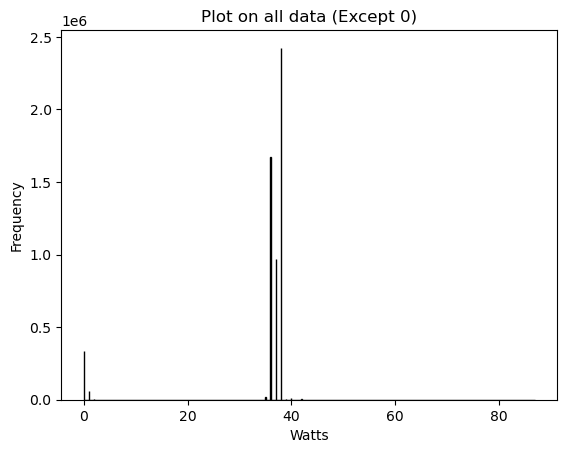

In [6]:
plot_distribution(array=original_df.select("P").to_numpy(), 
                  min=0,
                  max=100,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

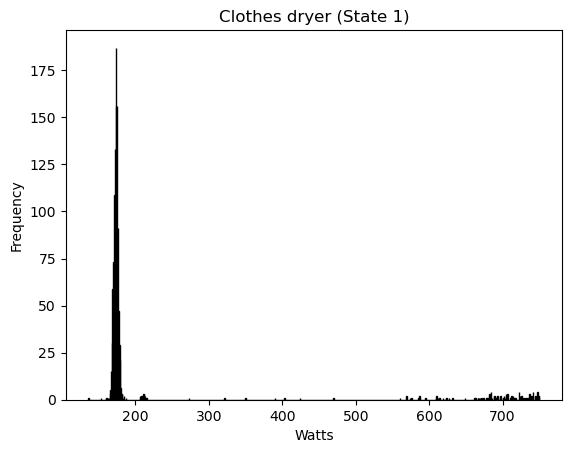

In [7]:
plot_distribution(array=original_df.select("P").to_numpy(), 
                  min=100, 
                  max=750,
                  plot_name="Clothes dryer (State 1)", 
                  unit_name="Watts")

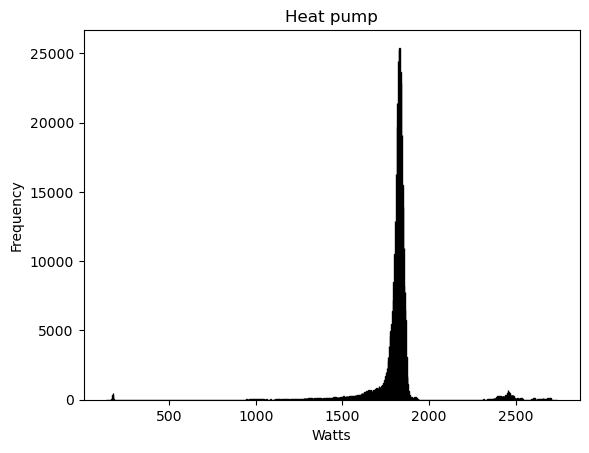

In [11]:
plot_distribution(array=original_df.select("P").to_numpy(), 
                  min=100, 
                  max=3000,
                  plot_name="Heat pump", 
                  unit_name="Watts")

__This device has two states__
- No device running: P < 40 (W)
- State 1: From 150 < P < 225 (W)
- State 2: From P > 600  (W)

## Get running segments

In [12]:
original_dfs = get_running_segments(input_df=original_df, min_length=10, smallest_threshold=500)

Processing segments: 100%|██████████| 419/419 [00:27<00:00, 15.37it/s]


In [13]:
len(original_dfs)

419

In [14]:
original_dfs[4].head()

,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,f64,f64,f64,str
49127,1457355915,0.2,0.880952,37.0,16.0,42.0,"""heat_pump"""
49128,1457355916,5.4,0.85822,569.0,287.0,663.0,"""heat_pump"""
49129,1457355917,6.5,0.912102,716.0,280.0,785.0,"""heat_pump"""
49130,1457355918,6.8,0.922424,761.0,279.0,825.0,"""heat_pump"""
49131,1457355919,7.0,0.933728,789.0,273.0,845.0,"""heat_pump"""


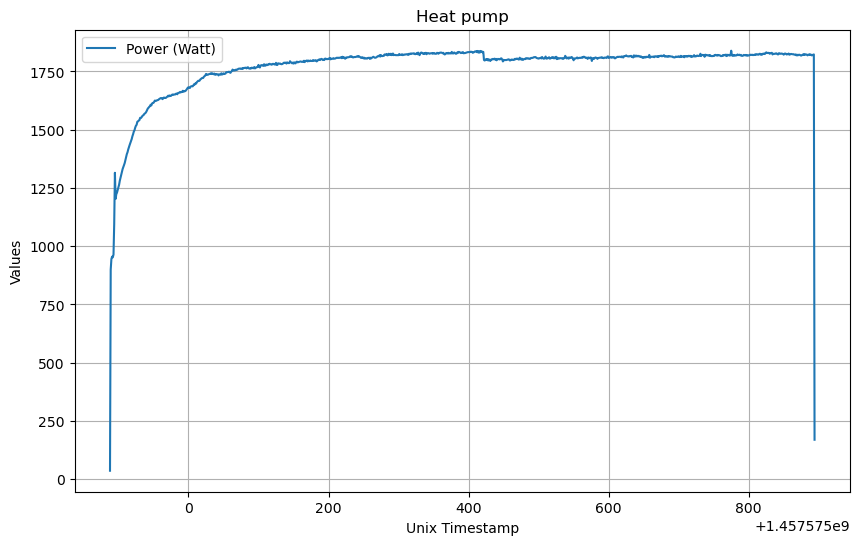

In [18]:
plot_data(original_dfs[50], {
        "name": "Heat pump",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [19]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/heat_pump"
for i in range(len(original_dfs)):
    original_df = original_dfs[i]
    original_df.to_pandas().to_excel(os.path.join(output_path, f"heat_pump_{i}.xlsx"))

# Lights and plugs 20

In [13]:
h2_lp20 = pl.read_csv("../../data/RAE_dataset/transform_data/raw/house2_lights_and_plugs_20.csv")
print(len(h2_lp20))
h2_lp20.head()

4980389


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1505286000,0.0,0.0,0,0,0,"""lights_and_plu…"
1,1505286001,0.0,0.0,0,0,2,"""lights_and_plu…"
2,1505286002,0.0,0.0,0,0,2,"""lights_and_plu…"
3,1505286003,0.0,0.0,0,0,0,"""lights_and_plu…"
4,1505286004,0.0,0.0,0,0,0,"""lights_and_plu…"


## Distribution plot

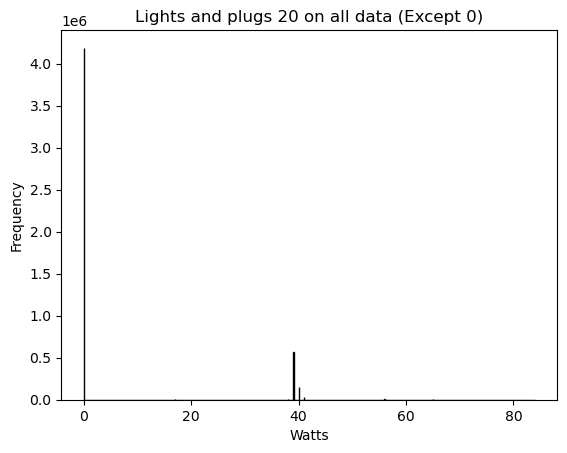

In [14]:
plot_distribution(array=h2_lp20.select("P").to_numpy(), 
                  min=None, 
                  max=None,
                  plot_name="Lights and plugs 20 on all data (Except 0)", 
                  unit_name="Watts")

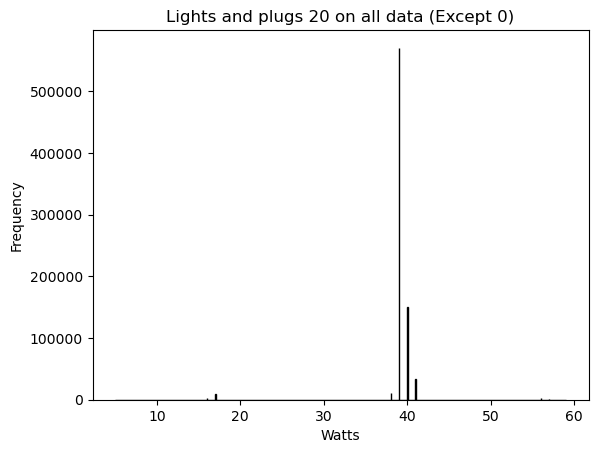

In [15]:
plot_distribution(array=h2_lp20.select("P").to_numpy(), 
                  min=5, 
                  max=60,
                  plot_name="Lights and plugs 20 on all data (Except 0)", 
                  unit_name="Watts")

=> Min threshold = 30

## Getting running segments

In [16]:
h2_lp20_running_dfs = get_running_segments(input_df=h2_lp20, min_length=10, smallest_threshold=30)
print(f"Overall dataframe: {len(h2_lp20_running_dfs)}")

Processing segments: 100%|██████████| 388/388 [00:24<00:00, 15.88it/s]

Overall dataframe: 372


In [ ]:
for i in range(20, 25):
    plot_data(input_df=h2_lp20_running_dfs[i], which_plot={
        "name": "LP16 data",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [19]:
export_to_files(output_path="../../data/RAE_dataset/transform_data/running_segments/lp20", 
                device_name="lights_and_plugs_20", 
                dfs=h2_lp20_running_dfs)


Exporting to file: 100%|██████████| 372/372 [01:13<00:00,  5.07it/s]


# Bedroom Plug

## Distribution Plot

In [ ]:
base_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/raw"
bedroom_plug_df = pl.read_csv(f"{base_path}/house1_upstairs_bedroom_AFCI_arc-fault_plugs.csv")
print(len(bedroom_plug_df))
bedroom_plug_df.head()

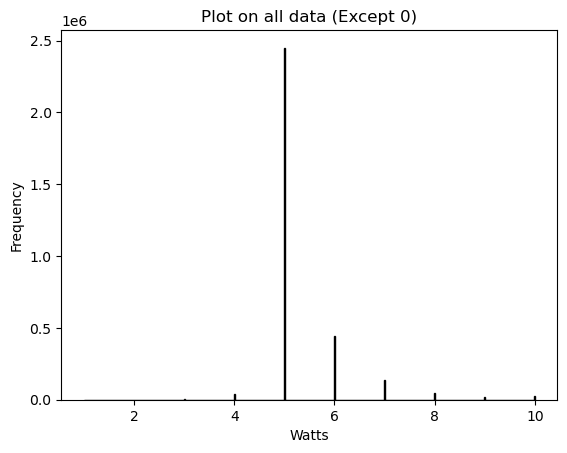

In [72]:
plot_distribution(array=bedroom_plug_df.select("P").to_numpy(), 
                  min=0,
                  max=10,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

Thiết bị ở trạng thái bình thường: 5-20W
State 1: 25 - 200 (W)
State 2: 200 - 1400 (W)

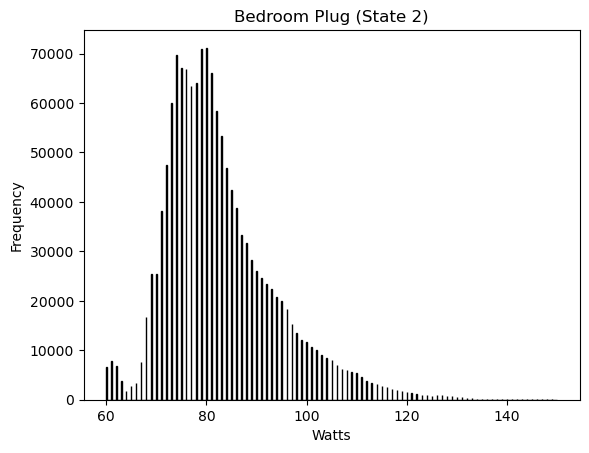

In [86]:
plot_distribution(array=bedroom_plug_df.select("P").to_numpy(), 
                  min=60, 
                  max=150,
                  plot_name="Bedroom Plug (State 2)", 
                  unit_name="Watts")

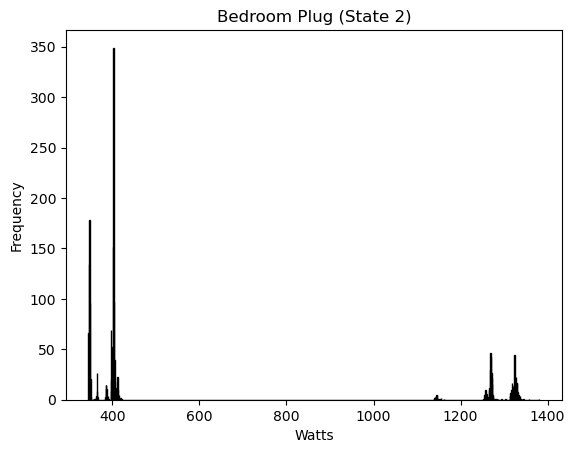

In [76]:
plot_distribution(array=bedroom_plug_df.select("P").to_numpy(), 
                  min=200, 
                  max=None,
                  plot_name="Bedroom Plug (State 2)", 
                  unit_name="Watts")

## Get running segments

In [90]:
bedroom_plug_dfs = get_running_segments(input_df=bedroom_plug_df, min_length=10, smallest_threshold=15)

Processing segments: 100%|██████████| 11035/11035 [14:29<00:00, 12.70it/s]


In [92]:
len(bedroom_plug_dfs)

3837

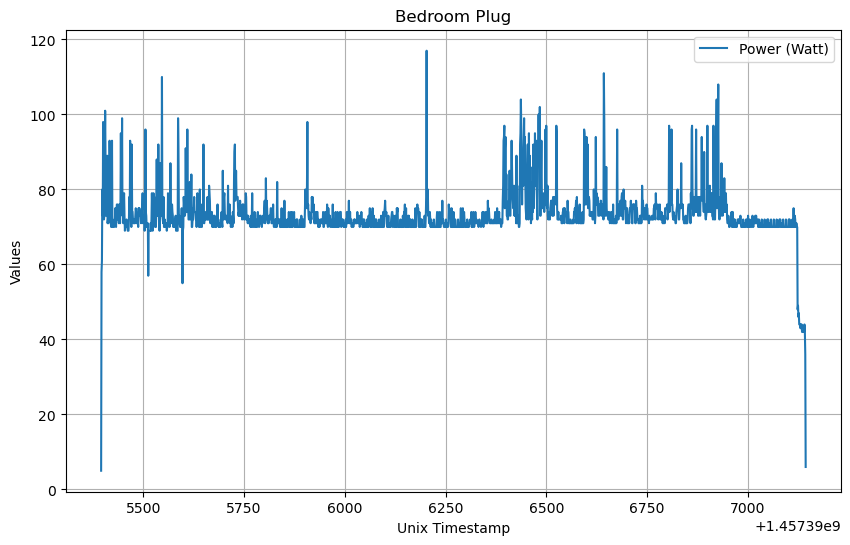

In [93]:
plot_data(bedroom_plug_dfs[8], {
        "name": "Bedroom Plug",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [94]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/bedroom_plug"
for i in range(len(bedroom_plug_dfs)):
    bedroom_plug_df = bedroom_plug_dfs[i]
    bedroom_plug_df.to_pandas().to_excel(os.path.join(output_path, f"Bedroom_plug_{i}.xlsx"))

# Clothes Washer

## Distribution plot

In [ ]:
clothes_washer_df = pl.read_csv(f"{base_path}/house1_clothes_washer.csv")
print(len(clothes_washer_df))
clothes_washer_df.head(10000)

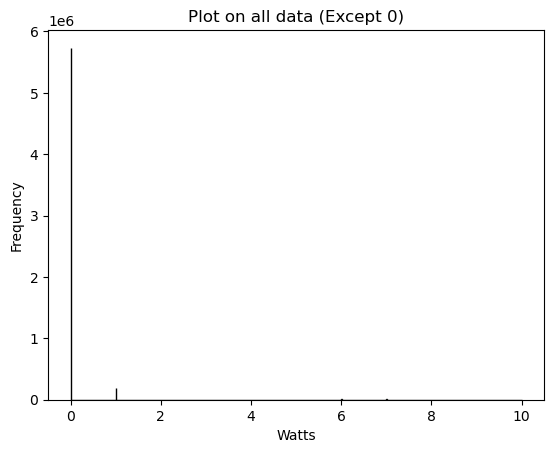

In [22]:
plot_distribution(array=clothes_washer_df.select("P").to_numpy(), 
                  min=0,
                  max=10,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

Mach khi binh thuong co P = 0W

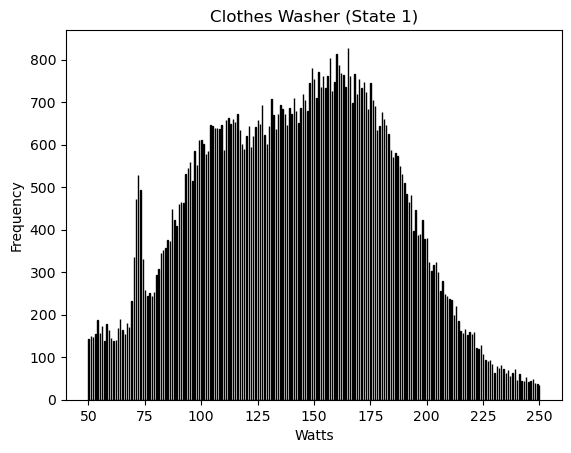

In [23]:
plot_distribution(array=clothes_washer_df.select("P").to_numpy(), 
                  min=50, 
                  max=250,
                  plot_name="Clothes Washer (State 1)", 
                  unit_name="Watts")

State 1 hoat dong trong khoang 50 - 250W

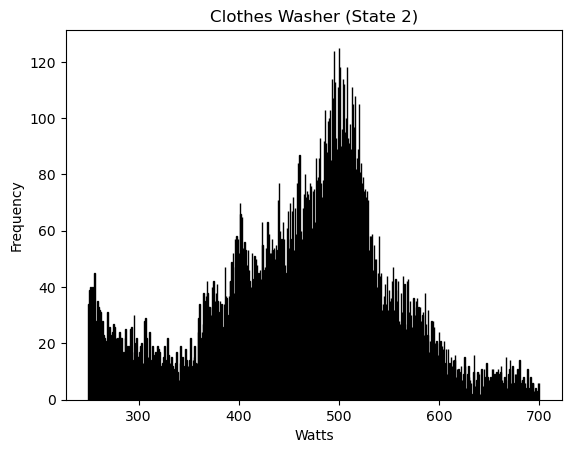

In [24]:
plot_distribution(array=clothes_washer_df.select("P").to_numpy(), 
                  min=250, 
                  max=700,
                  plot_name="Clothes Washer (State 2)", 
                  unit_name="Watts")

State 2 khoang 250 - 1100W

## Get running segment

In [25]:
clothes_washer_dfs = get_running_segments(input_df=clothes_washer_df, min_length=10, smallest_threshold=45)

Processing segments: 100%|██████████| 5673/5673 [07:08<00:00, 13.23it/s]


In [26]:
len(clothes_washer_dfs)

3490

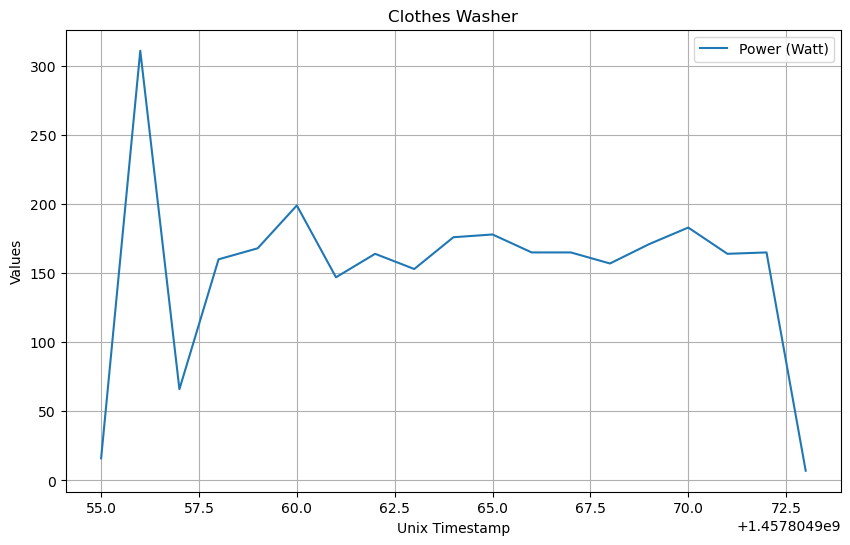

In [28]:
plot_data(clothes_washer_dfs[8], {
        "name": "Clothes Washer",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [24]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/clothes_washer"
for i in range(len(clothes_washer_dfs)):
    clothes_washer_df = clothes_washer_dfs[i]
    clothes_washer_df.to_pandas().to_excel(os.path.join(output_path, f"Clothes_washer{i}.xlsx"))

# Kitchen Dishwasher

## Distribution plot

In [45]:
kitchen_dishwasher_df = pl.read_csv(f"{base_path}/house1_kitchen_dishwasher.csv")
print(len(kitchen_dishwasher_df))
kitchen_dishwasher_df.head(5000)

6068210


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,i64,i64,i64,str
0,1457251200,0.0,0.0,0,0,0,"""kitchen_dishwa…"
1,1457251201,0.0,0.0,0,0,0,"""kitchen_dishwa…"
2,1457251202,0.0,0.0,0,0,0,"""kitchen_dishwa…"
3,1457251203,0.0,0.0,0,0,0,"""kitchen_dishwa…"
4,1457251204,0.0,0.0,0,0,0,"""kitchen_dishwa…"
5,1457251205,0.0,0.0,0,0,0,"""kitchen_dishwa…"
6,1457251206,0.0,0.0,0,0,0,"""kitchen_dishwa…"
7,1457251207,0.0,0.0,0,0,0,"""kitchen_dishwa…"
8,1457251208,0.0,0.0,0,0,0,"""kitchen_dishwa…"


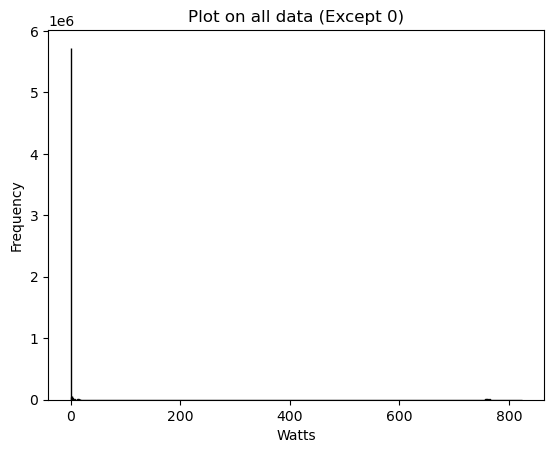

In [47]:
plot_distribution(array=kitchen_dishwasher_df.select("P").to_numpy(), 
                  min=0,
                  max=None,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

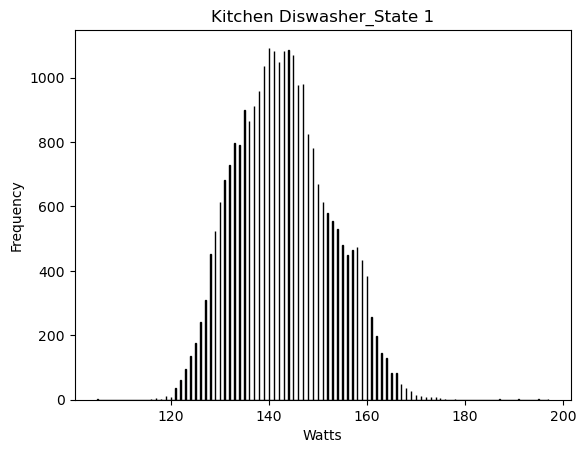

In [49]:
plot_distribution(array=kitchen_dishwasher_df.select("P").to_numpy(), 
                  min=100,
                  max=200,
                  plot_name="Kitchen Diswasher_State 1", 
                  unit_name="Watts")

State 1: 120 - 180W

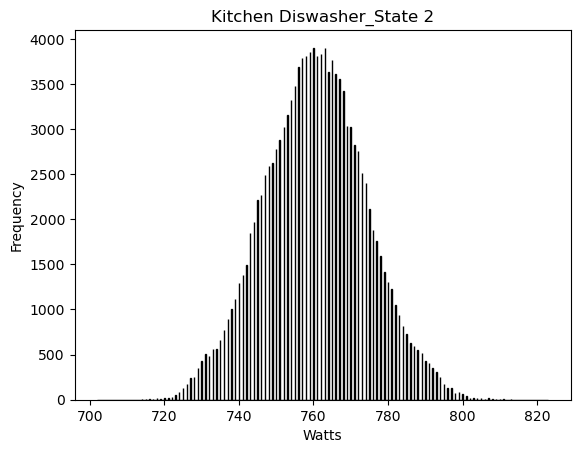

In [48]:
plot_distribution(array=kitchen_dishwasher_df.select("P").to_numpy(), 
                  min=700,
                  max=1500,
                  plot_name="Kitchen Diswasher_State 2", 
                  unit_name="Watts")

State 2: 700 - 800W

## Get running segment

In [88]:
kitchen_dishwasher_dfs = get_running_segments(input_df=kitchen_dishwasher_df, min_length=50, smallest_threshold=100)

Processing segments: 100%|██████████| 219/219 [00:17<00:00, 12.65it/s]


In [57]:
len(kitchen_dishwasher_dfs)

211

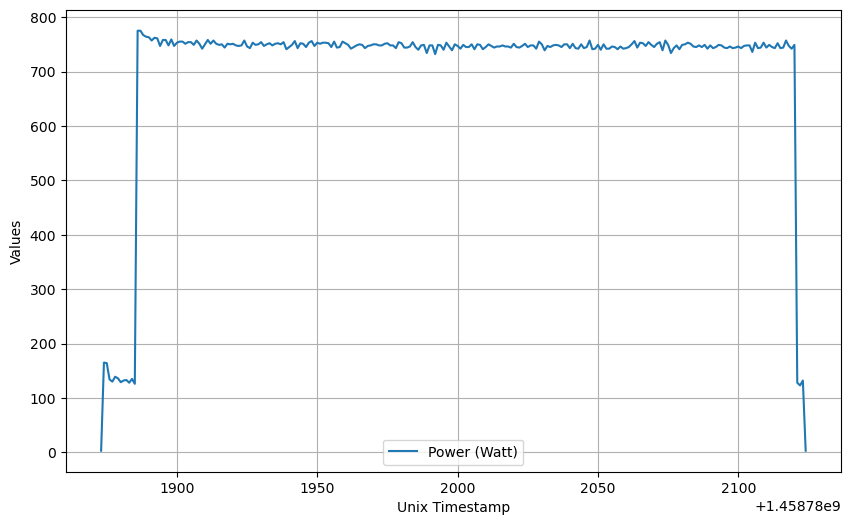

In [65]:
plot_data(kitchen_dishwasher_dfs[34], {
        "name": "",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [89]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/kitchen_diswasher"
for i in range(len(kitchen_dishwasher_dfs)):
    kitchen_dishwasher_df = kitchen_dishwasher_dfs[i]
    kitchen_dishwasher_df.to_pandas().to_excel(os.path.join(output_path, f"Kitchen Dishwasher{i}.xlsx"))

# Furniture_and_hot_water_unit:

## Distribution plot:

In [ ]:
furniture_and_unit_df = pl.read_csv(f"{base_path}/house1_furnace_and_hot_water_unit.csv")
print(len(furniture_and_unit_df))
furniture_and_unit_df.head(5000)

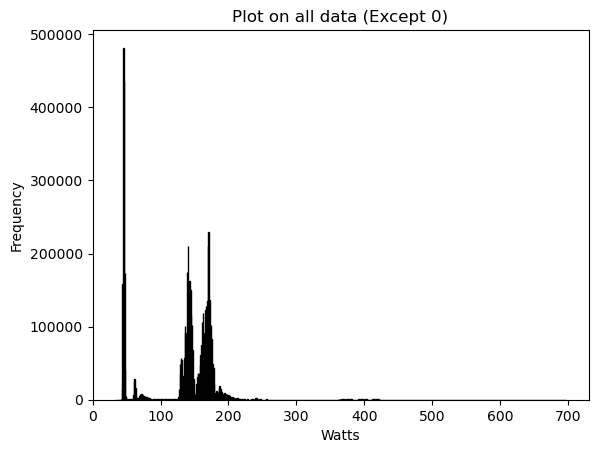

In [30]:
plot_distribution(array=furniture_and_unit_df.select("P").to_numpy(), 
                  min=0,
                  max=None,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

khi không hoạt động thì hệ có năng lượng khoảng 42-50W

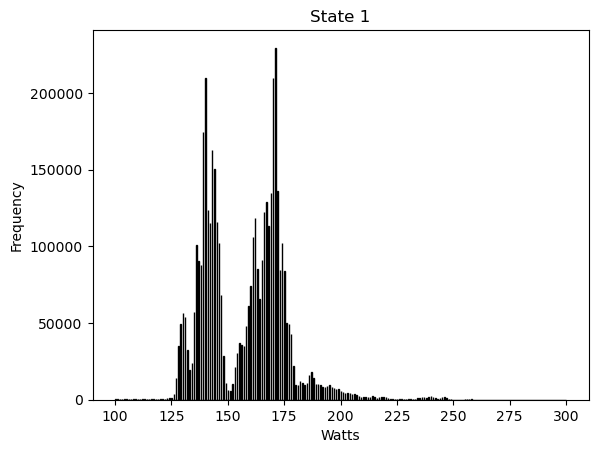

In [6]:
plot_distribution(array=furniture_and_unit_df.select("P").to_numpy(), 
                  min=100,
                  max=300,
                  plot_name="State 1", 
                  unit_name="Watts")

State 1 hoạt động trong khoảng 125 - 225W

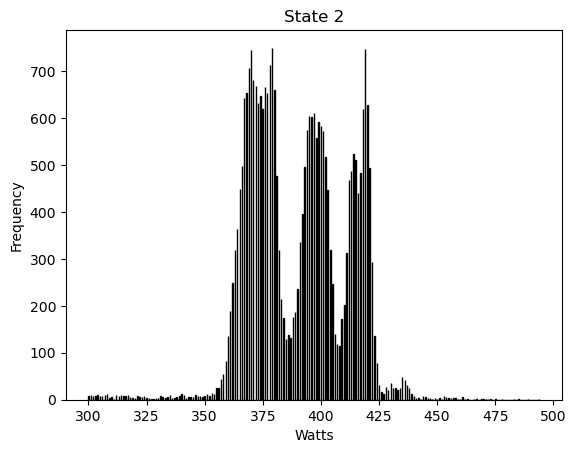

In [7]:
plot_distribution(array=furniture_and_unit_df.select("P").to_numpy(), 
                  min=300,
                  max=500,
                  plot_name="State 2", 
                  unit_name="Watts")

State 2: 300 - 475W. Tập trung nhiều trong khoảng 350-425W

## Get running segment

In [31]:
furniture_and_unit_dfs = get_running_segments(input_df=furniture_and_unit_df, min_length=100, smallest_threshold=100)

Processing segments: 100%|██████████| 6802/6802 [08:29<00:00, 13.35it/s]


In [45]:
len(furniture_and_unit_dfs)

0

In [47]:
plot_data(furniture_and_unit_dfs[0], {
        "name": "Bedroom Plug",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

IndexError: list index out of range

In [65]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/furniture_and_hot_water_unit"
for i in range(len(furniture_and_unit_dfs)):
    furniture_and_unit_df = furniture_and_unit_dfs[i]
    furniture_and_unit_df.to_pandas().to_excel(os.path.join(output_path, f"Furniture and Hot Water Unit{i}.xlsx"))

# Bathroom

## Distribution plot

In [ ]:
bathroom_df = pl.read_csv(f"{base_path}/house1_bathrooms.csv")
print(len(bathroom_df))
bathroom_df.head(1000)

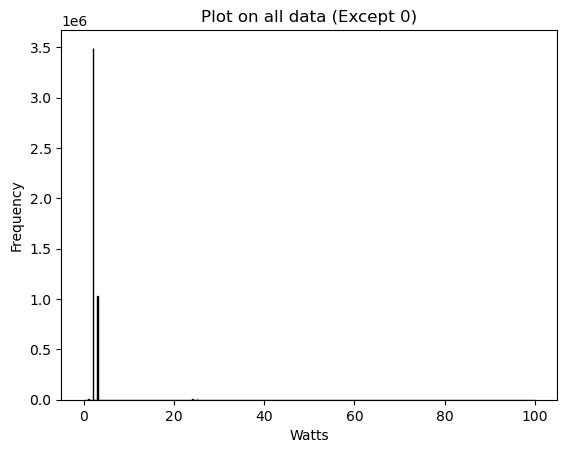

In [31]:
plot_distribution(array=bathroom_df.select("P").to_numpy(), 
                  min=0,
                  max=100,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

Khi khong hoạt động thì thiết bị có công suất khoảng 3-4W

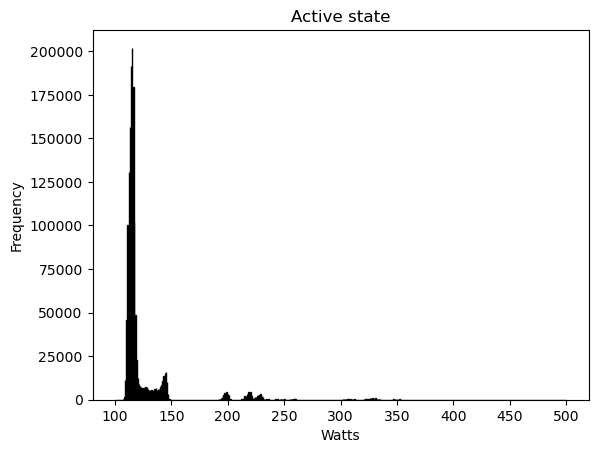

In [33]:
plot_distribution(array=bathroom_df.select("P").to_numpy(), 
                  min=100,
                  max=500,
                  plot_name="Active state", 
                  unit_name="Watts")

Trạng thái hoạt động: 100-150W

## Get running segment:

In [34]:
bathroom_dfs = get_running_segments(input_df=bathroom_df, min_length=10, smallest_threshold=100)

Processing segments: 100%|██████████| 2877/2877 [03:10<00:00, 15.10it/s]


In [35]:
len(bathroom_dfs)

2651

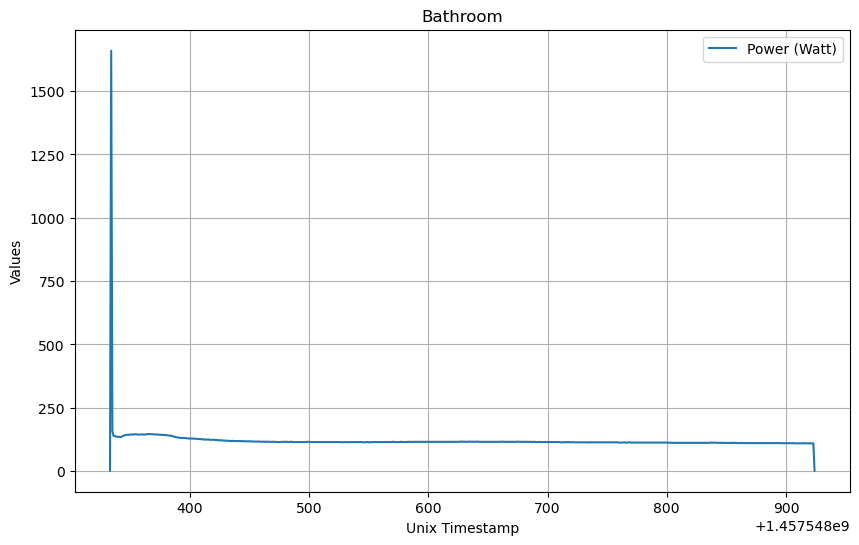

In [38]:
plot_data(bathroom_dfs[100], {
        "name": "Bathroom",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [81]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/bathroom"
for i in range(len(bathroom_dfs)):
    bathroom_df = bathroom_dfs[i]
    bathroom_df.to_pandas().to_excel(os.path.join(output_path, f"Bathroom{i}.xlsx"))

# Basement Blue Plug

In [ ]:
basement_plug_df = pl.read_csv(f"{base_path}/house1_basement_blue_plugs.csv")
print(len(basement_plug_df))
basement_plug_df.head(10)

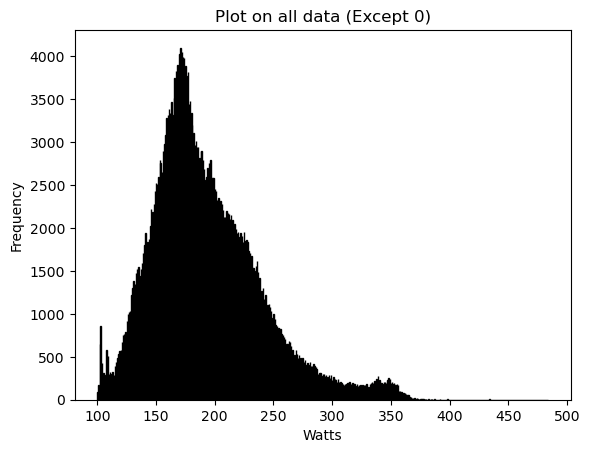

In [16]:
plot_distribution(array=basement_plug_df.select("P").to_numpy(), 
                  min=100,
                  max=500,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

Khi không hoạt động: P = 20 - 23W là nhiều nhất
Trạng thái hoạt động được ghi nhận ghi có P= 110-500W. Tap trung chu yeu khoang 150-200W

## Get running segment

In [17]:
basement_plug_dfs = get_running_segments(input_df=basement_plug_df, min_length=10, smallest_threshold=110)

Processing segments: 100%|██████████| 1753/1753 [02:19<00:00, 12.58it/s]


In [18]:
len(basement_plug_dfs)

1190

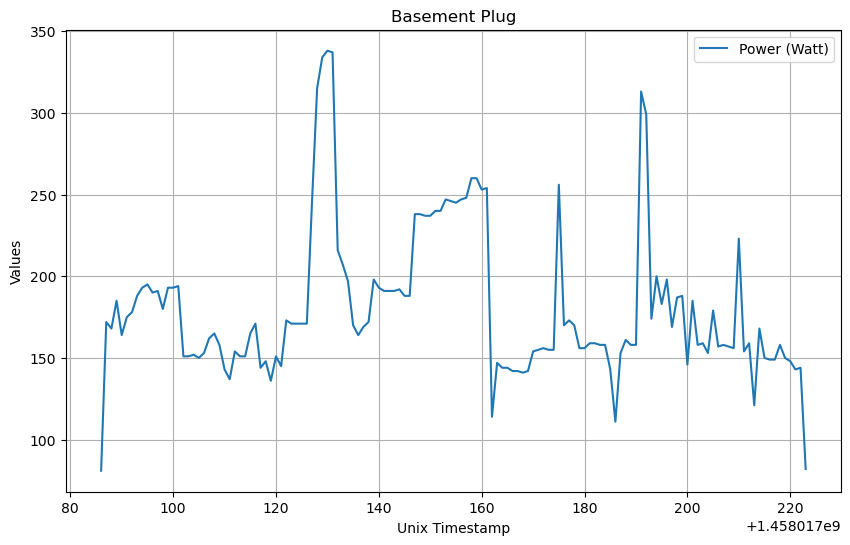

In [23]:
plot_data(basement_plug_dfs[100], {
        "name": "Basement Plug",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [116]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/basement_plug"
for i in range(len(basement_plug_dfs)):
    basement_plug_df = basement_plug_dfs[i]
    basement_plug_df.to_pandas().to_excel(os.path.join(output_path, f"Basement_blue_plug_{i}.xlsx"))

## Distribution plot

In [ ]:
basement_light_df = pl.read_csv(f"{base_path}/house1_basement_plugs_and_lights.csv")
print(len(basement_light_df))
basement_light_df.head(10)

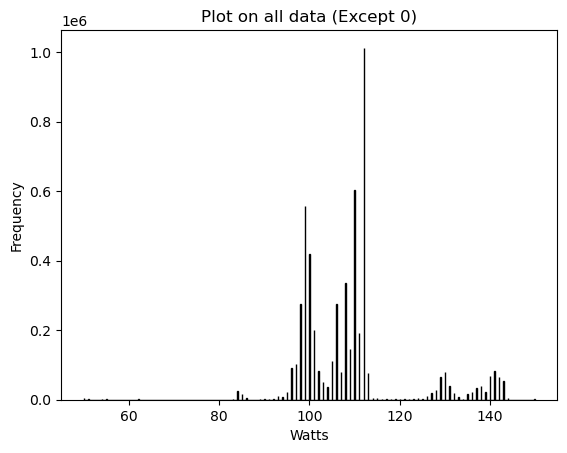

In [25]:
plot_distribution(array=basement_light_df.select("P").to_numpy(), 
                  min=50,
                  max=150,
                  plot_name="Plot on all data (Except 0)", 
                  unit_name="Watts")

Processing segments:   1%|          | 491/46387 [14:24<22:26:39,  1.76s/it]


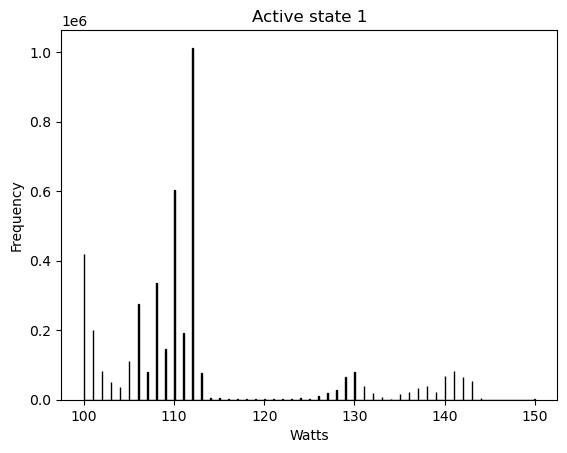

In [33]:
plot_distribution(array=basement_light_df.select("P").to_numpy(), 
                  min=100,
                  max=150,
                  plot_name="Active state 1", 
                  unit_name="Watts")

## Get running segment

In [7]:
basement_light_dfs = get_running_segments(input_df=basement_light_df, min_length=50, smallest_threshold=105)

Labeling ON/OFF:  27%|██▋       | 1635124/6068210 [00:01<00:04, 917480.05it/s]

Processing segments:  89%|████████▉ | 41206/46387 [1:06:53<07:03, 12.25it/s]

KeyboardInterrupt: 

Processing segments:  89%|████████▉ | 41206/46387 [1:07:13<07:03, 12.25it/s]

In [28]:
len(basement_light_dfs)

0

In [29]:
plot_data(basement_light_dfs[100], {
        "name": "Basement Plug",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

IndexError: list index out of range

In [ ]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/basement_plug_and_light"
for i in range(len(basement_light_dfs)):
    basement_light_df = basement_light_dfs[i]
    basement_light_df.to_pandas().to_excel(os.path.join(output_path, f"basement_plugs_and_lights_{i}.xlsx"))

# Kitchen couter plug

## Distribution plot

In [ ]:
kitchen_couter_df = pl.read_csv(f"{base_path}/house1_kitchen_counter_plugs.csv")
print(len(kitchen_couter_df))
kitchen_couter_df.head(5)

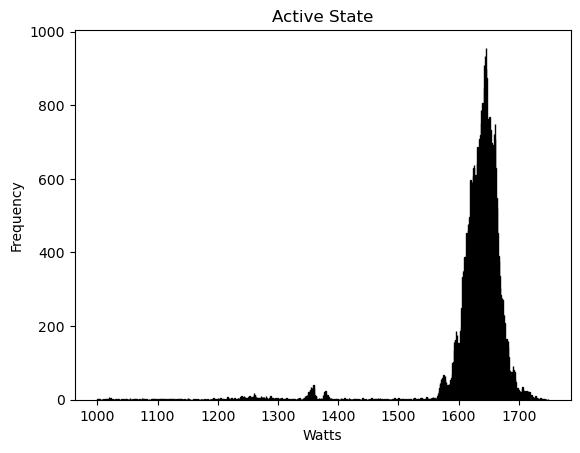

In [22]:
plot_distribution(array=kitchen_couter_df.select("P").to_numpy(), 
                  min=1000,
                  max=None,
                  plot_name="Active State", 
                  unit_name="Watts")

## Get running segment

In [23]:
kitchen_couter_dfs = get_running_segments(input_df=kitchen_couter_df, min_length=20, smallest_threshold=1000)

Processing segments: 100%|██████████| 1560/1560 [01:59<00:00, 13.06it/s]


In [24]:
len(kitchen_couter_dfs)

202

In [ ]:
plot_data(kitchen_couter_dfs[100], {
        "name": "Kitchen Counter Plug",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [26]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/kitchen_counter_plug"
for i in range(len(kitchen_couter_dfs)):
    kitchen_couter_df = kitchen_couter_dfs[i]
    kitchen_couter_df.to_pandas().to_excel(os.path.join(output_path, f"kitchen_counter_plug_{i}.xlsx"))

# Garage sub panel

## Distribution plot

In [ ]:
garage_sub_panel_df = pl.read_csv(f"{base_path}/house1_garage_sub_panel.csv")
print(len(garage_sub_panel_df))
garage_sub_panel_df.head(5)

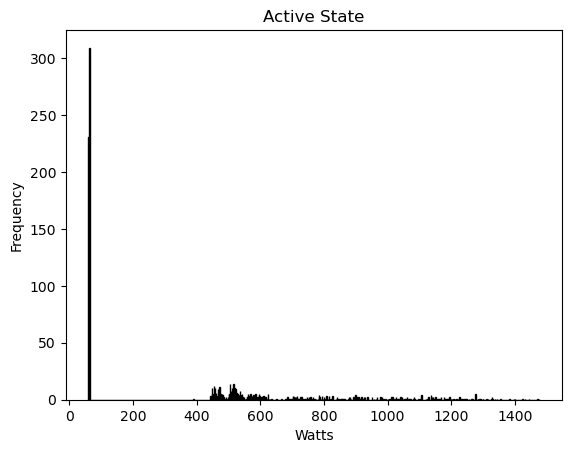

In [37]:
plot_distribution(array=garage_sub_panel_df.select("P").to_numpy(), 
                  min=10,
                  max=None,
                  plot_name="Active State", 
                  unit_name="Watts")

## Get running segment

In [40]:
garage_sub_panel_dfs = get_running_segments(input_df=garage_sub_panel_df, min_length=20, smallest_threshold=50)

Processing segments: 100%|██████████| 49/49 [00:03<00:00, 13.18it/s]


In [41]:
len(garage_sub_panel_dfs)

6

In [ ]:
plot_data(garage_sub_panel_dfs[5], {
        "name": "Garage Sub Panel",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [45]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/garage_sub_panel"
for i in range(len(garage_sub_panel_dfs)):
    garage_sub_panel_df = garage_sub_panel_dfs[i]
    garage_sub_panel_df.to_pandas().to_excel(os.path.join(output_path, f"garage_sub_panel_{i}.xlsx"))

# Upstair Plug

In [ ]:
upstair_plug_df = pl.read_csv(f"{base_path}/house1_upstairs_plug_and_lights.csv")
print(len(upstair_plug_df))
upstair_plug_df.head(5)

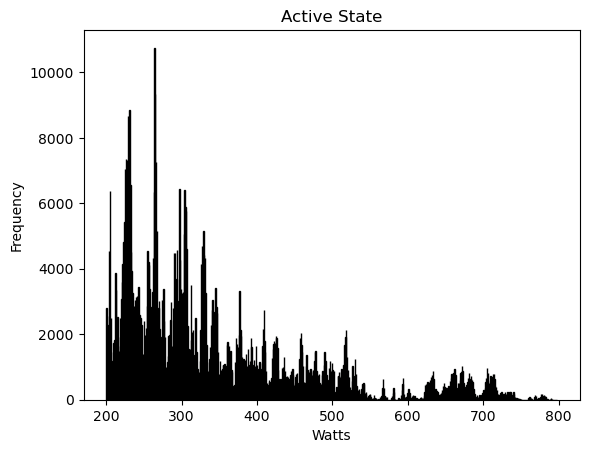

In [52]:
plot_distribution(array=upstair_plug_df.select("P").to_numpy(), 
                  min=200,
                  max=800,
                  plot_name="Active State", 
                  unit_name="Watts")

## Get running segment

In [56]:
upstair_plug_dfs = get_running_segments(input_df=upstair_plug_df, min_length=20, smallest_threshold=50)

Processing segments: 100%|██████████| 792/792 [01:01<00:00, 12.97it/s]


In [57]:
len(upstair_plug_dfs)

520

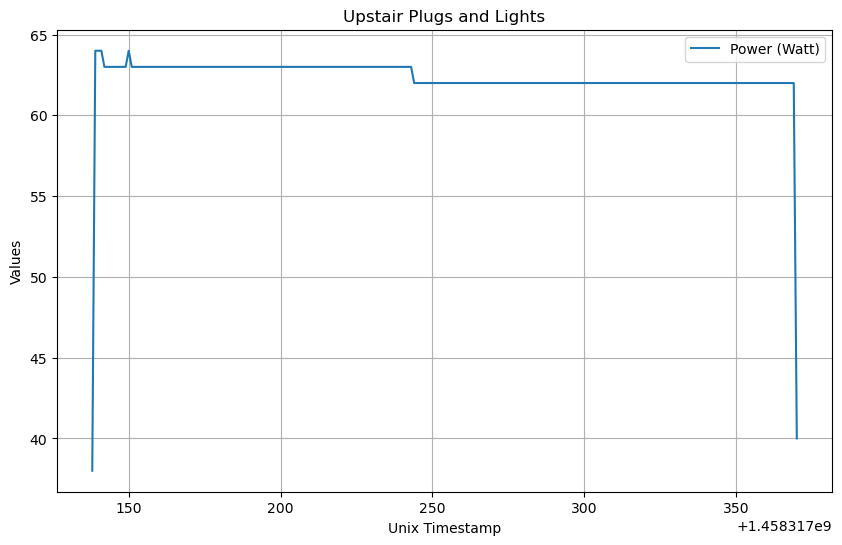

In [63]:
plot_data(upstair_plug_dfs[88], {
        "name": "Upstair Plugs and Lights",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [64]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/upstair_plugs"
for i in range(len(upstair_plug_dfs)):
    upstair_plug_df = upstair_plug_dfs[i]
    upstair_plug_df.to_pandas().to_excel(os.path.join(output_path, f"upstair_plugs_and_lights_{i}.xlsx"))

# Rental Sub Panel

## Distribution Plot:

In [3]:
rental_sub_panel_df = pl.read_csv(f"{base_path}/house1_rental_suite_sub_panel.csv")
print(len(rental_sub_panel_df))
rental_sub_panel_df.head(5)

6068210


,unix_ts,Irms,pf,P,Q,S,label
i64,i64,f64,f64,f64,f64,f64,str
0,1457251200,0.5,0.657143,46.0,10.0,70.0,"""rental_suite_s…"
1,1457251201,0.5,0.657143,46.0,10.0,70.0,"""rental_suite_s…"
2,1457251202,0.5,0.671429,47.0,10.0,70.0,"""rental_suite_s…"
3,1457251203,0.5,0.671429,47.0,10.0,70.0,"""rental_suite_s…"
4,1457251204,0.5,0.657143,46.0,11.0,70.0,"""rental_suite_s…"


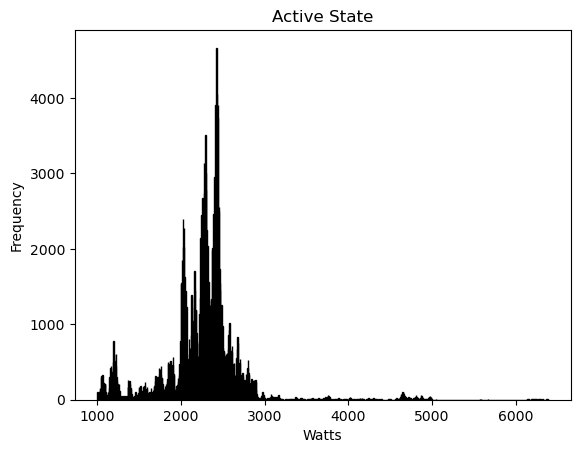

In [13]:
plot_distribution(array=rental_sub_panel_df.select("P").to_numpy(), 
                  min=1000,
                  max=None,
                  plot_name="Active State", 
                  unit_name="Watts")

## Get running segment:

In [6]:
rental_sub_panel_dfs = get_running_segments(input_df=rental_sub_panel_df, min_length=20, smallest_threshold=60)

Labeling ON/OFF:  12%|█▏        | 710272/6068210 [00:00<00:02, 2395683.58it/s]

Processing segments: 100%|██████████| 4977/4977 [06:07<00:00, 13.55it/s]


In [9]:
len(rental_sub_panel_dfs)

3439

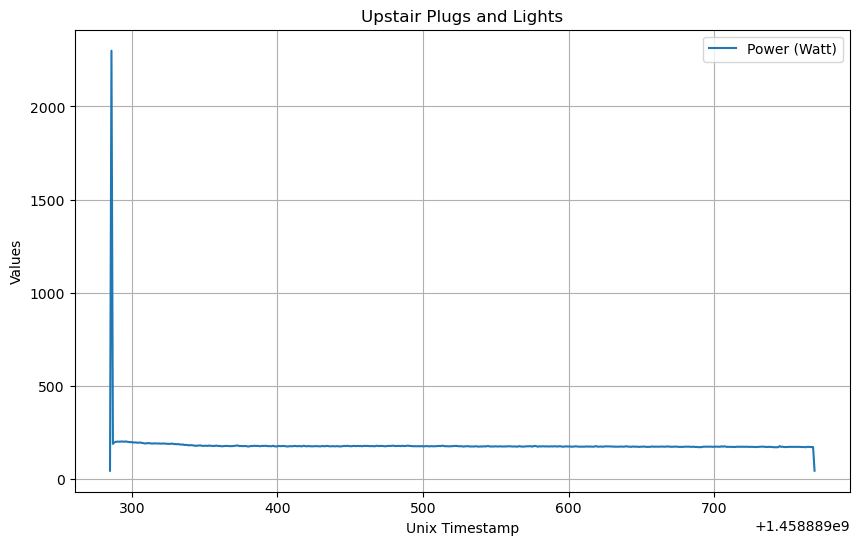

In [14]:
plot_data(rental_sub_panel_dfs[800], {
        "name": "Upstair Plugs and Lights",
        "Irms": False,
        "P": True,
        "pf": False,
        "Q": False,
        "S": False
    })

In [ ]:
output_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/RAE_dataset/transform_data/running_segments/rental_suite_sub_panel"
for i in range(len(rental_sub_panel_dfs)):
    rental_sub_panel_df = rental_sub_panel_dfs[i]
    rental_sub_panel_df.to_pandas().to_excel(os.path.join(output_path, f"rental_suite_sub_panel_{i}.xlsx"))